# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,Imputer,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# altering pandas plot limit
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

print('Files Loaded')

Files Loaded


##### AZDIAS summary

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [7]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [9]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [10]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

In [12]:
# Data Examples before changing 'AGER_TYP','CAMEO_DEUG_2015','MOBI_REGIO',
data_example = 'AGER_TYP'
azdias[data_example].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [13]:
missing_values_substitution = []

# Running each column of the features
for index, row in feat_info.iterrows():
    
    # Transforming text to array
    keys = row['missing_or_unknown'].replace("[", "").replace("]", "").split(",")
    
    keys_substitution = []
    total_replaces = 0
    
    # For each type of missing value    
    for missing_key in keys:       
        
        # Number of changes and changing values 
        grouped = azdias[row['attribute']].value_counts()
        qtd = 0
        
        # Transforming to float if not text
        missing_key_fix = missing_key
        if missing_key_fix not in ['','X','XX']:
            missing_key_fix = float(missing_key)
        
        if missing_key_fix in grouped:
            qtd = grouped[missing_key_fix]         
            azdias[row['attribute']] = azdias[row['attribute']].replace({missing_key_fix:None})
            total_replaces += qtd
        
        # Saving change log for each key         
        keys_substitution.append([missing_key_fix,qtd])
        
    # Saving Changes
    missing_values_substitution.append( [ row['attribute'], keys_substitution,total_replaces])

# Saving Changes made on a Dataframe
df_missing_data = pd.DataFrame(missing_values_substitution, columns=['attribute','replace_list','qtd_replaced'])    
    
print(' ---- Missing Values to Nan Complete ---- ')
# df_missing_data

 ---- Missing Values to Nan Complete ---- 


*[Preprocessing] All missing values have been re-encoded in a consistent way as NaNs*

In [14]:
# Data Examples After changing 'AGER_TYP','CAMEO_DEUG_2015','MOBI_REGIO',
azdias[data_example].value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
columns_na = pd.DataFrame(azdias.isnull().sum(), columns = ['qtd_na'])
columns_na['attribute'] = columns_na.index
print('Dataframe of Nan created')

Dataframe of Nan created


In [16]:
columns_na.head(2)

,qtd_na,attribute
AGER_TYP,685843,AGER_TYP
ALTERSKATEGORIE_GROB,2881,ALTERSKATEGORIE_GROB


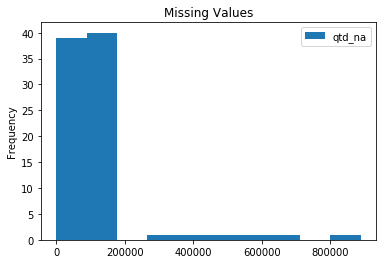

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
columns_na.plot(kind='hist')
plt.title('Missing Values')
plt.show()

In [18]:
columns_na.sort_values(by=['qtd_na'],ascending=False)

,qtd_na,attribute
TITEL_KZ,889061,TITEL_KZ
AGER_TYP,685843,AGER_TYP
KK_KUNDENTYP,584612,KK_KUNDENTYP
KBA05_BAUMAX,476524,KBA05_BAUMAX
GEBURTSJAHR,392318,GEBURTSJAHR
ALTER_HH,310267,ALTER_HH
KKK,158064,KKK
REGIOTYP,158064,REGIOTYP
W_KEIT_KIND_HH,147988,W_KEIT_KIND_HH
KBA05_ANTG1,133324,KBA05_ANTG1


With the graph above, we can see some outlier that has 200.000 data missing out of 891.221

Those columns are: ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']

Then there are 3 blocks of missing data:

- 70.000 to 150.000
-  2.000 to  20.000
- Not Missing Any

*[preprocessing] Columns with a large amount of missing values have been removed from the analysis. Patterns in missing values have been identified between other columns.*

AGER_TYP categorical


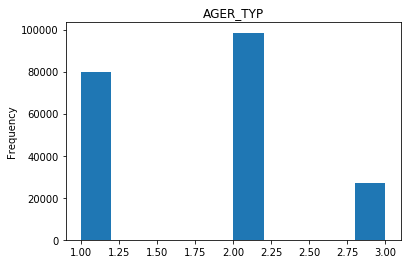

ALTERSKATEGORIE_GROB ordinal


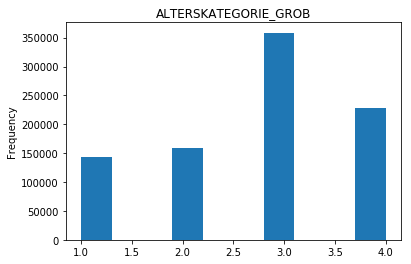

ANREDE_KZ categorical


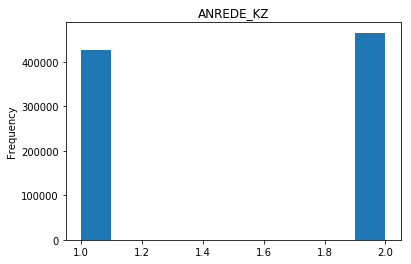

CJT_GESAMTTYP categorical


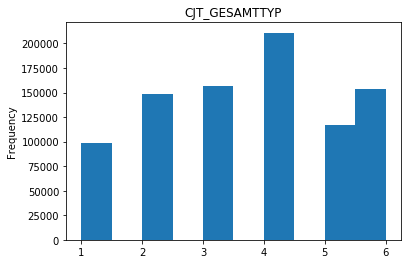

FINANZ_MINIMALIST ordinal


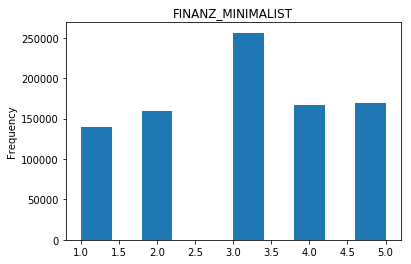

FINANZ_SPARER ordinal


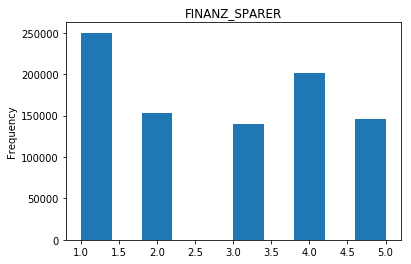

FINANZ_VORSORGER ordinal


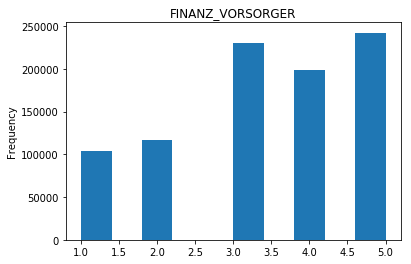

FINANZ_ANLEGER ordinal


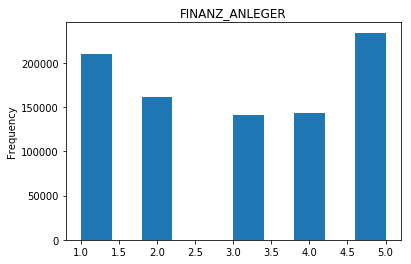

FINANZ_UNAUFFAELLIGER ordinal


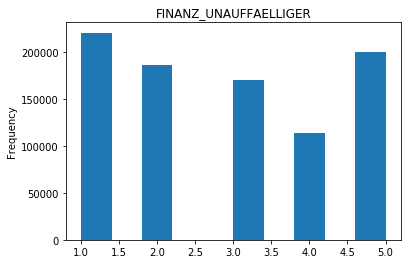

FINANZ_HAUSBAUER ordinal


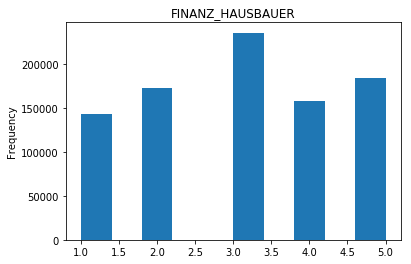

FINANZTYP categorical


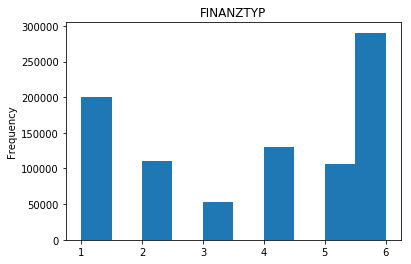

GEBURTSJAHR numeric


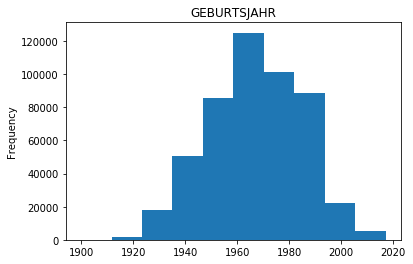

GFK_URLAUBERTYP categorical


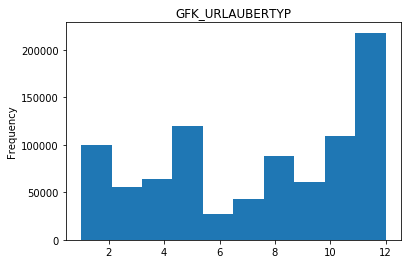

GREEN_AVANTGARDE categorical


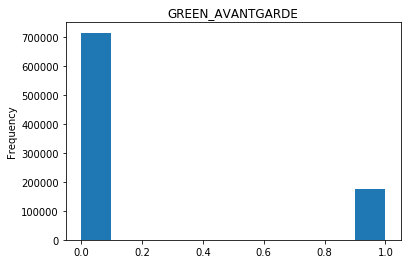

HEALTH_TYP ordinal


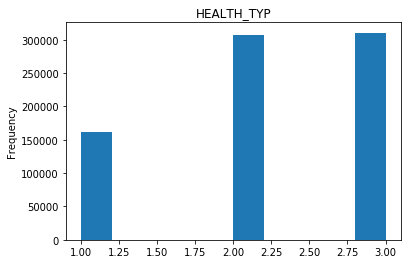

LP_LEBENSPHASE_FEIN mixed


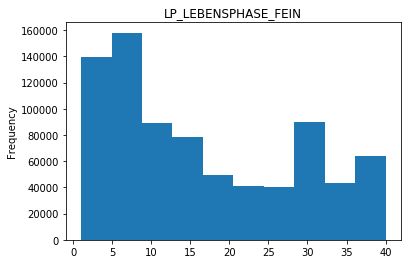

LP_LEBENSPHASE_GROB mixed


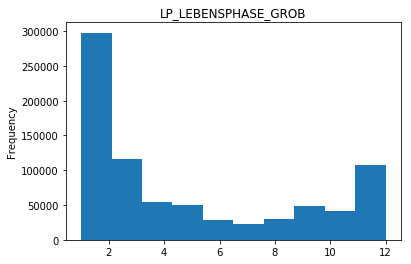

LP_FAMILIE_FEIN categorical


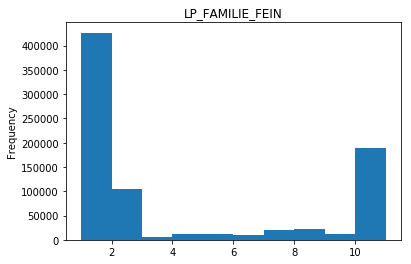

LP_FAMILIE_GROB categorical


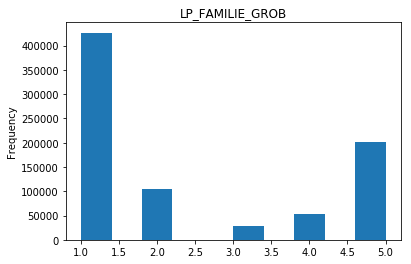

LP_STATUS_FEIN categorical


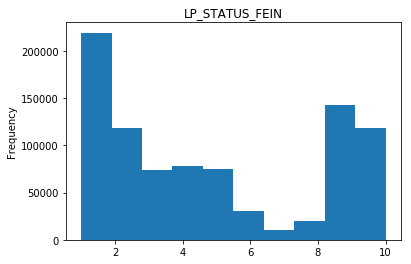

LP_STATUS_GROB categorical


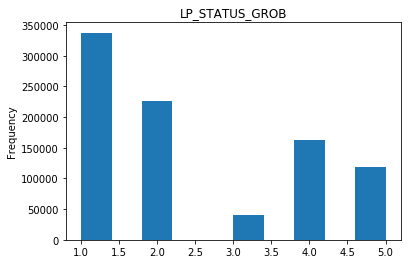

NATIONALITAET_KZ categorical


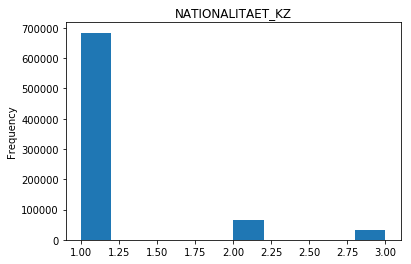

PRAEGENDE_JUGENDJAHRE mixed


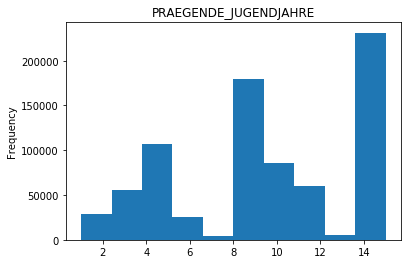

RETOURTYP_BK_S ordinal


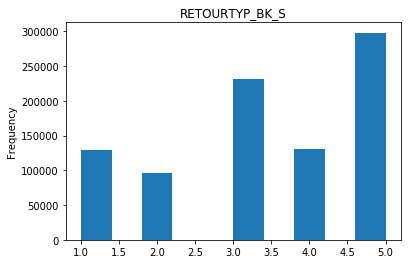

SEMIO_SOZ ordinal


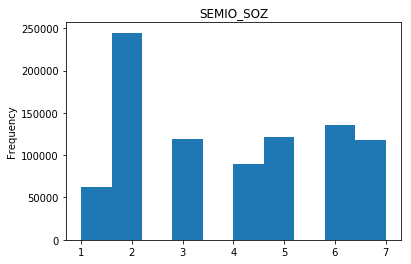

SEMIO_FAM ordinal


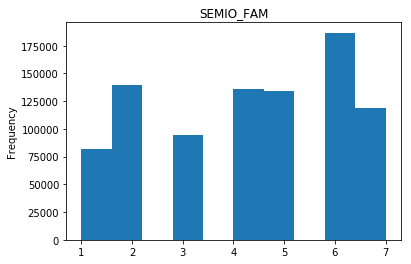

SEMIO_REL ordinal


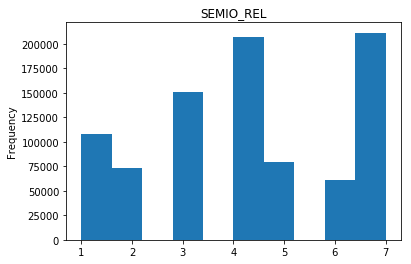

SEMIO_MAT ordinal


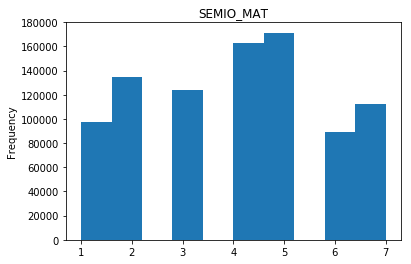

SEMIO_VERT ordinal


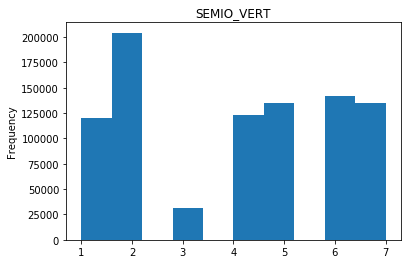

SEMIO_LUST ordinal


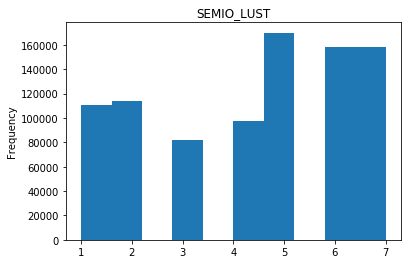

SEMIO_ERL ordinal


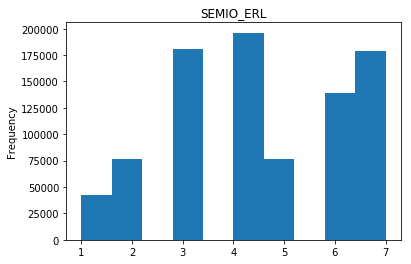

SEMIO_KULT ordinal


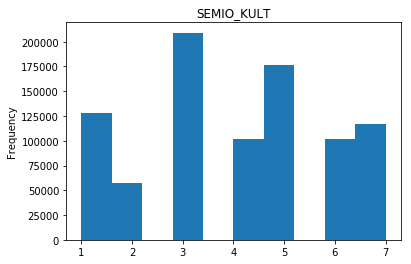

SEMIO_RAT ordinal


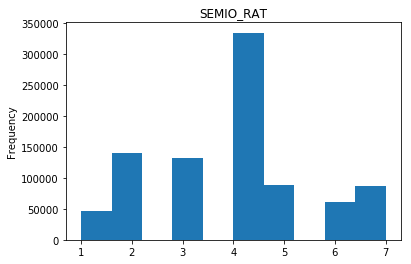

SEMIO_KRIT ordinal


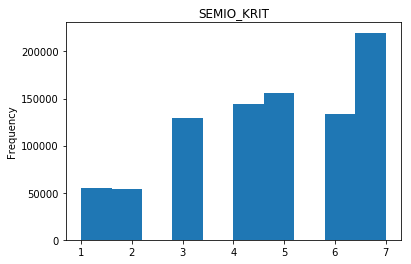

SEMIO_DOM ordinal


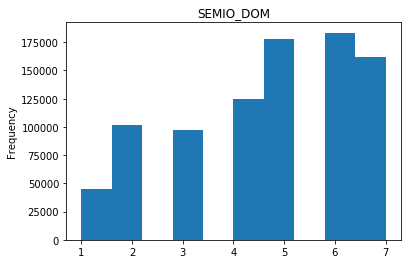

SEMIO_KAEM ordinal


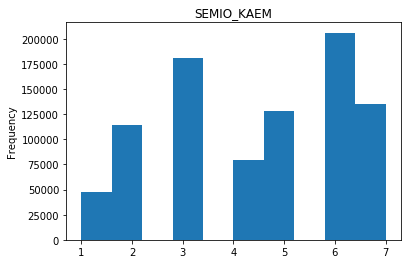

SEMIO_PFLICHT ordinal


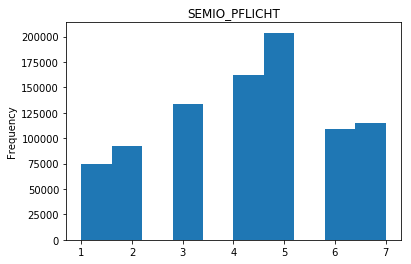

SEMIO_TRADV ordinal


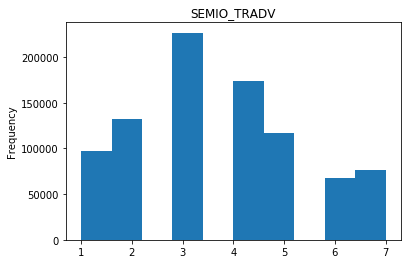

SHOPPER_TYP categorical


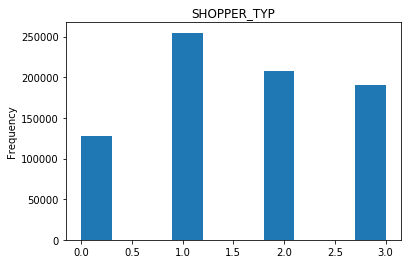

SOHO_KZ categorical


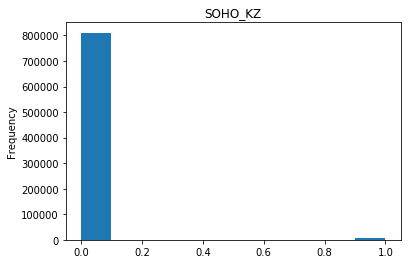

TITEL_KZ categorical


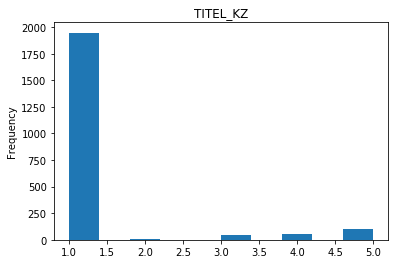

VERS_TYP categorical


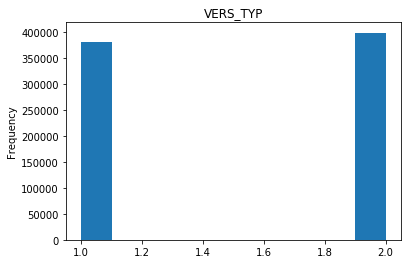

ZABEOTYP categorical


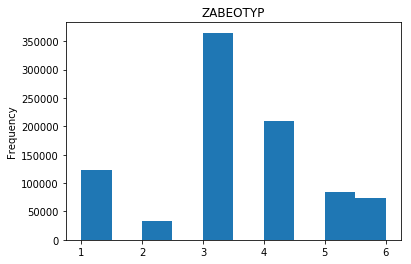

ALTER_HH interval


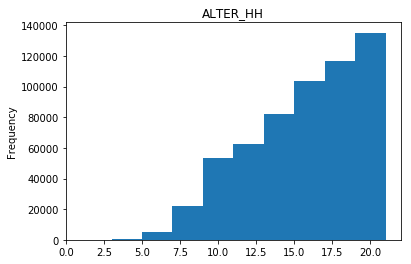

ANZ_PERSONEN numeric


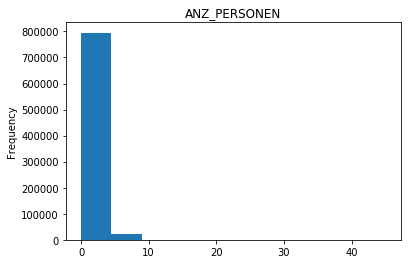

ANZ_TITEL numeric


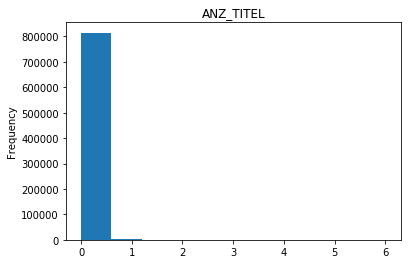

HH_EINKOMMEN_SCORE ordinal


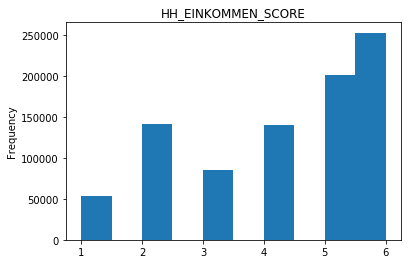

KK_KUNDENTYP categorical


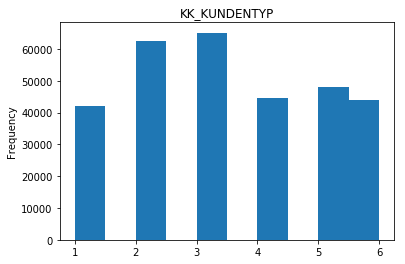

W_KEIT_KIND_HH ordinal


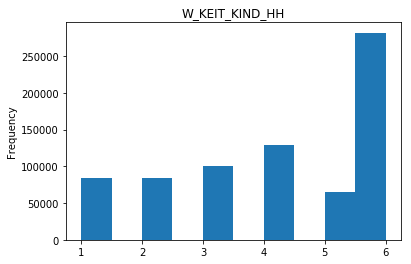

WOHNDAUER_2008 ordinal


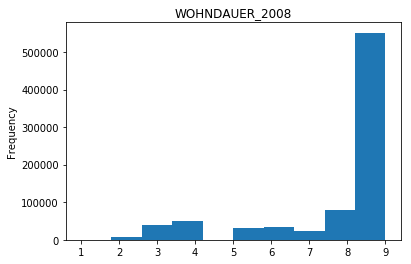

ANZ_HAUSHALTE_AKTIV numeric


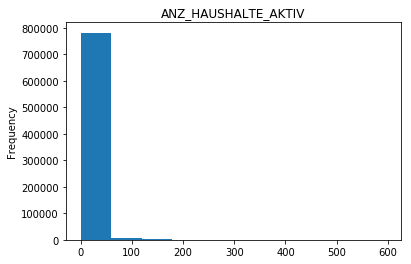

ANZ_HH_TITEL numeric


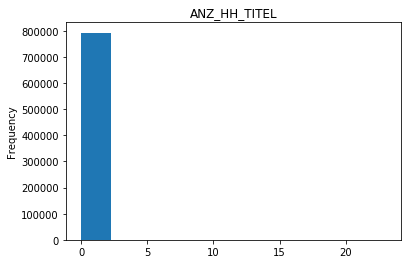

GEBAEUDETYP categorical


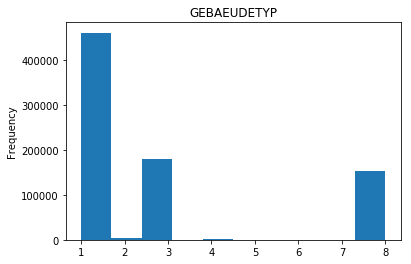

KONSUMNAEHE ordinal


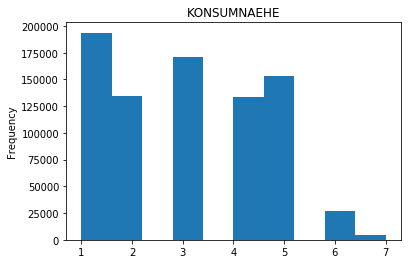

MIN_GEBAEUDEJAHR numeric


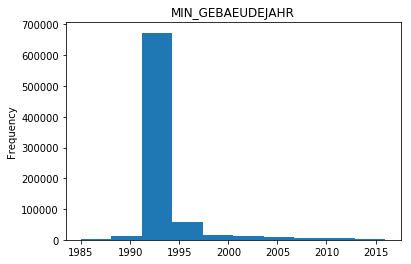

OST_WEST_KZ categorical
 --- Invalid Plot --- 
WOHNLAGE mixed


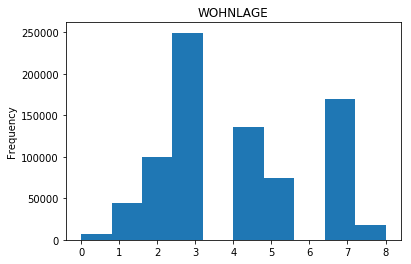

CAMEO_DEUG_2015 categorical
 --- Invalid Plot --- 
CAMEO_DEU_2015 categorical
 --- Invalid Plot --- 
CAMEO_INTL_2015 mixed
 --- Invalid Plot --- 
KBA05_ANTG1 ordinal


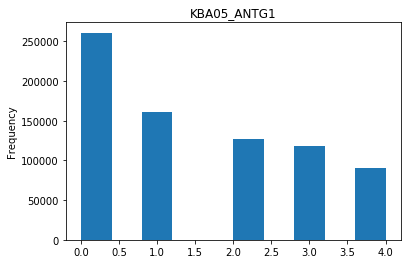

KBA05_ANTG2 ordinal


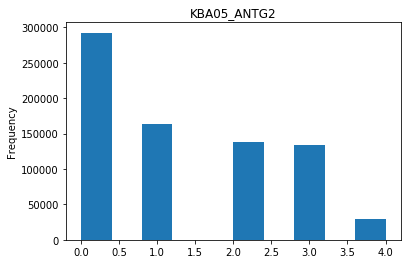

KBA05_ANTG3 ordinal


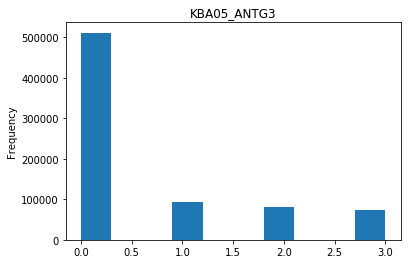

KBA05_ANTG4 ordinal


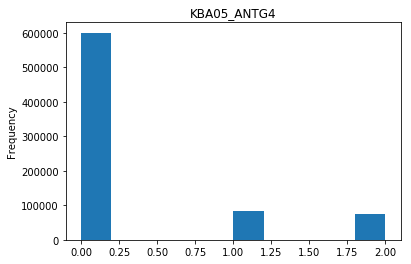

KBA05_BAUMAX mixed


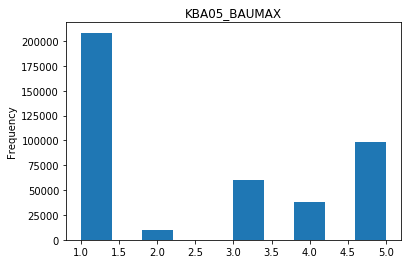

KBA05_GBZ ordinal


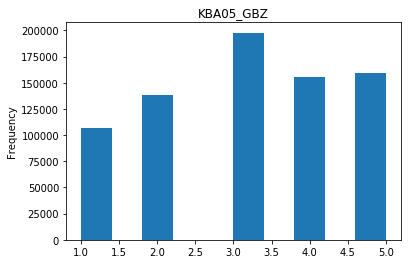

BALLRAUM ordinal


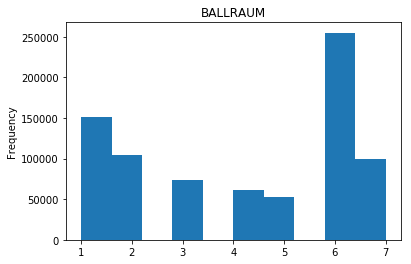

EWDICHTE ordinal


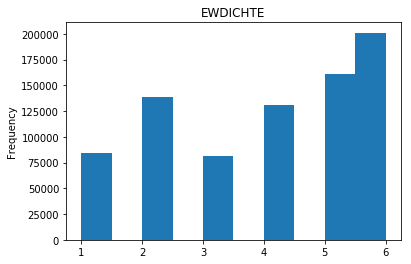

INNENSTADT ordinal


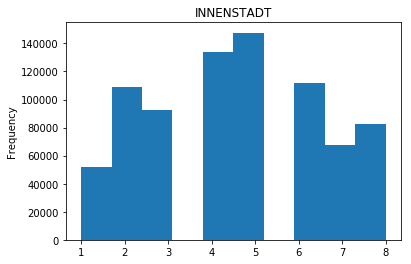

GEBAEUDETYP_RASTER ordinal


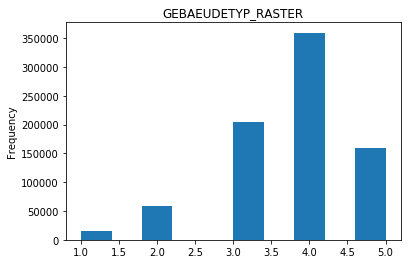

KKK ordinal


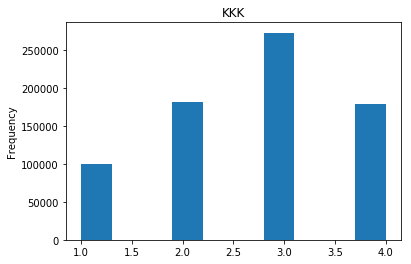

MOBI_REGIO ordinal


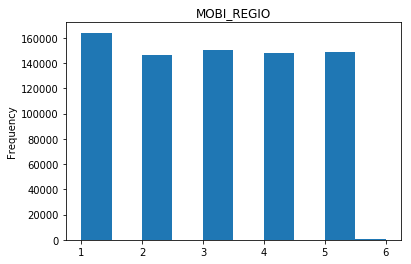

ONLINE_AFFINITAET ordinal


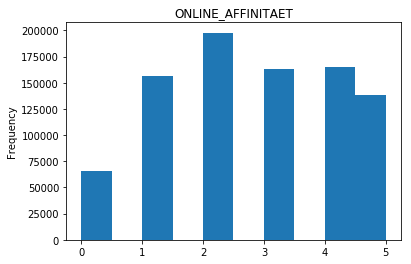

REGIOTYP ordinal


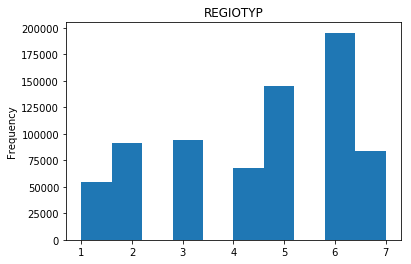

KBA13_ANZAHL_PKW numeric


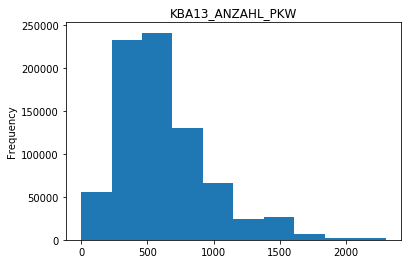

PLZ8_ANTG1 ordinal


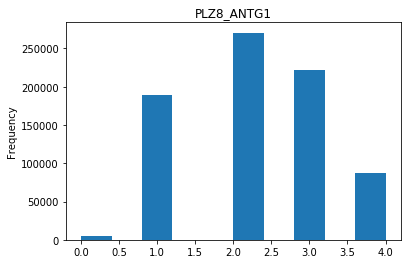

PLZ8_ANTG2 ordinal


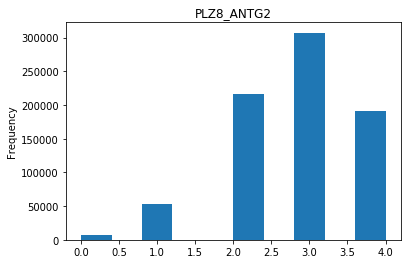

PLZ8_ANTG3 ordinal


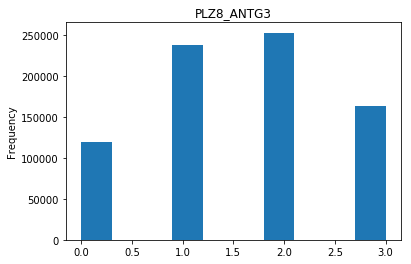

PLZ8_ANTG4 ordinal


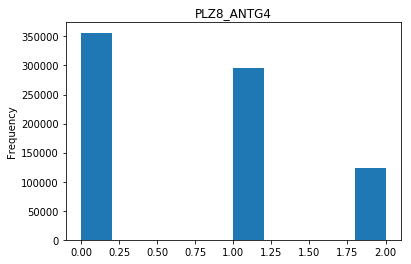

PLZ8_BAUMAX mixed


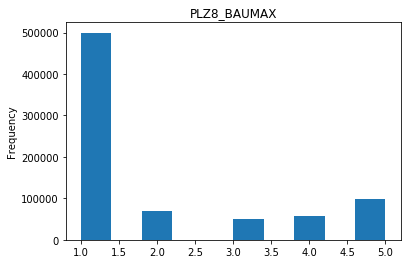

PLZ8_HHZ ordinal


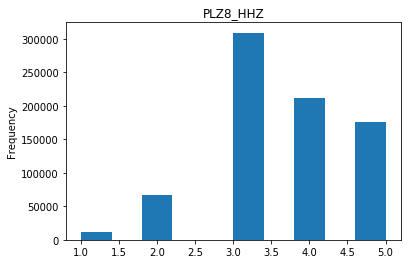

PLZ8_GBZ ordinal


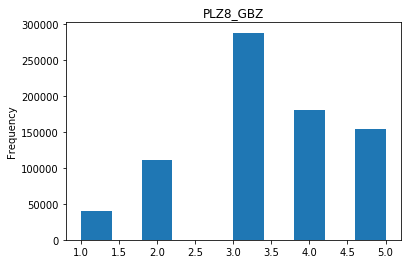

ARBEIT ordinal


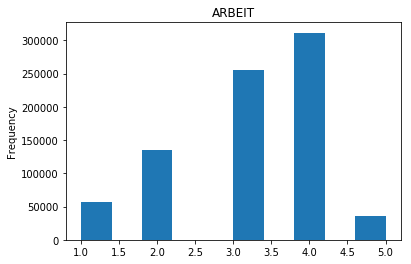

ORTSGR_KLS9 ordinal


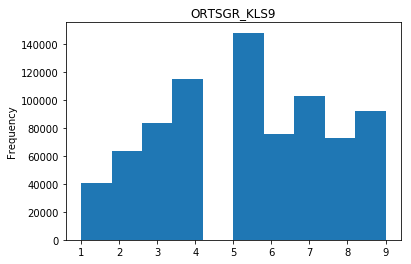

RELAT_AB ordinal


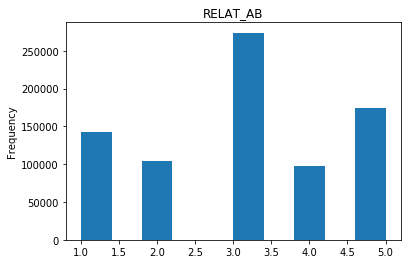

In [19]:
# Investigate patterns in the amount of missing data in each column.

# Running each column of the features
for index, row in feat_info.iterrows():
    print(row['attribute'],row['type'])
    
    try:
        azdias[row['attribute']].plot(kind='hist')
        plt.title(row['attribute'])
        plt.show()
        
    except:
        print(' --- Invalid Plot --- ')

#### Invalid Histograms
With the previous plot we encounter the following columns that has no numeric values

['OST_WEST_KZ ','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']

In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outliers = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']

azdias = azdias.drop(columns = outliers)

print('Nan Outliers removed')

Nan Outliers removed



#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

1.Are there any patterns in missing values?

Yes there are four:

- 300.000 to 800.000
-  70.000 to 150.000
-   2.000 to  20.000
-  Not Missing Any

2.Which columns were removed from the dataset?

['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']

For now we will remove only those.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
# Counting Null in each row

row_na = pd.DataFrame(azdias.isnull().sum(axis=1), columns = ['qtd_na'])
print('Dataframe of Nan created')

Dataframe of Nan created


In [22]:
row_na.head(3)

,qtd_na
0,43
1,0
2,0


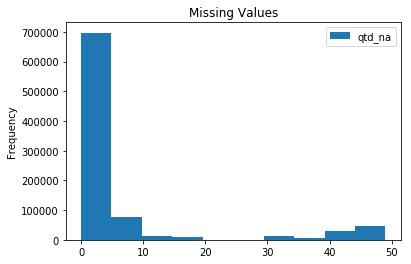

In [23]:
# Row Distribution on each row
row_na.plot(kind='hist')
plt.title('Missing Values')
plt.show()

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Getting with rows are above or below the thrshold
threshold = 25
row_na['threshold'] = row_na['qtd_na'] > threshold

# # Setting on the primary dataset 
# azdias = pd.concat([azdias, row_na], axis=1, sort=False)

azdias_lowna = azdias[row_na['threshold']==False]
azdias_highna = azdias[row_na['threshold']]

print('Separation is done by threshold columns')

Separation is done by threshold columns


In [25]:
azdias_lowna.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1,2,5.0,1,5,2,5,4,5,1,10.0,0,3,21,6,5,3,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,2,5,2.0,0.0,6.0,3,9.0,11,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2,1.0,3.0,3,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3,5,4
2,3,2,3.0,1,4,1,2,3,5,1,10.0,1,3,3,1,1,1,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,1,5,1.0,0.0,4.0,3,9.0,10,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2,3.0,2.0,2,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3,5,2


In [26]:
azdias_highna.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,1,2.0,3,4,3,5,5,3,4,10.0,0,None,15,4,2,2,1.0,1.0,None,None,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,None,NaN,None,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2,1,6.0,3,4,3,5,5,3,4,5.0,0,None,None,None,None,None,5.0,2.0,None,None,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,None,NaN,None,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
azdias.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,1,2.0,3,4,3,5,5,3,4,10.0,0,None,15,4,2,2,1.0,1.0,None,None,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,None,NaN,None,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,5.0,1,5,2,5,4,5,1,10.0,0,3,21,6,5,3,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,2,5,2.0,0.0,6.0,3,9.0,11,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2,1.0,3.0,3,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3,5,4


In [28]:
row_na.head(2)

,qtd_na,threshold
0,43,True
1,0,False


In [29]:
azdias_highna.shape

(93260, 79)

In [30]:
azdias_lowna.shape

(797961, 79)

In [31]:
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

------------


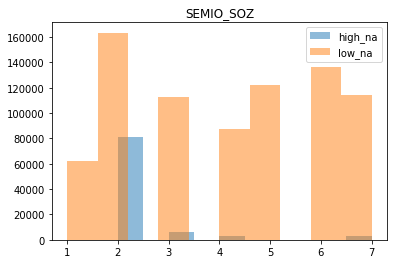

------------


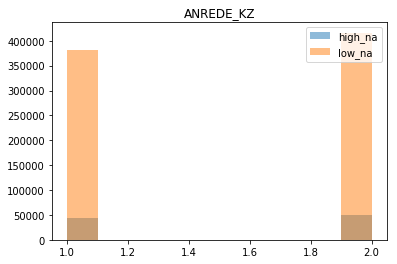

------------


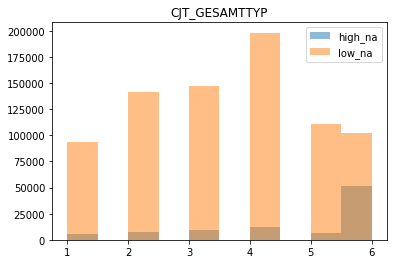

------------


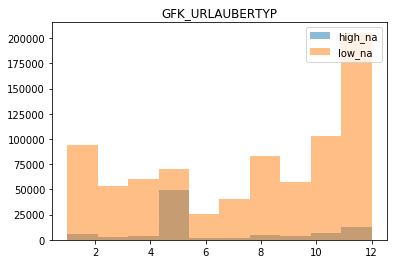

------------


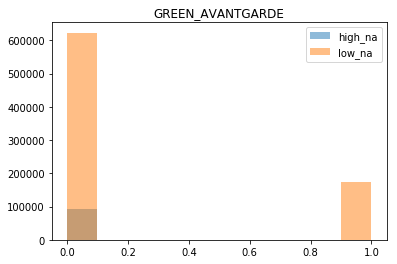

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns_to_compare = ['SEMIO_SOZ','ANREDE_KZ', 'CJT_GESAMTTYP','GFK_URLAUBERTYP', 'GREEN_AVANTGARDE']
for col in columns_to_compare:
    print('------------')
    plt.hist(azdias_highna[col].dropna(), alpha=0.5, label='high_na')
    plt.hist(azdias_lowna[col].dropna() , alpha=0.5, label='low_na')
    plt.legend(loc='upper right')
    plt.title(col)
    plt.show()
    


*[preprocessing]The data has been split into two parts based on how much data is missing from each row. The subsets have been compared to see if they are qualitatively different from one another.*

#### Discussion 1.1.3: Assess Missing Data in Each Row

1-Are the data with lots of missing values are qualitatively different from data with few or no missing values?

Yes, they are.

From the five columns checked: ['SEMIO_SOZ','ANREDE_KZ', 'CJT_GESAMTTYP','GFK_URLAUBERTYP', 'GREEN_AVANTGARDE']

- 'SEMIO_SOZ'        - Has a different distribution
- 'ANREDE_KZ'        - Is ok
- 'CJT_GESAMTTYP'    - Has a different distribution
- 'GFK_URLAUBERTYP'  - Has a different distribution
- 'GREEN_AVANTGARDE' - Is ok

From the columns checked, the rows with high None values do not follow the distribution from the rest of the sample.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [34]:
feat_info[feat_info['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [35]:
feat_info[feat_info['type']=='categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# --- WORKING ON THE FEEDBACK
# You should explore this OST_WEST_KZ feature a bit more here. Instead of one hot encoding this feature 
# (and creating an unnecessary column), you should encode the OST_WEST_KZ feature numerically 
# (e.g. as 0, 1 instead of 'O', 'W' or vice versa).

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

current_columns = azdias_lowna.columns
columns_to_encode = []
columns_bolleans_to_adjust = []

# Running every categorical
for index,row in feat_info[feat_info['type']=='categorical'].iterrows():
    
    # Getting only the atributes that are in the current dataset    
    if row['attribute'] in current_columns:
        
        atribute_distribution = azdias_lowna[row['attribute']].value_counts()
        atribute_options = atribute_distribution.index
        
        # Checking if it is boolean. (Or a 2 level category)
        boolean = False
        if len(atribute_options) == 2:
            boolean = True
            #if not all(atribute_options.sort_values()==[0,1]):
            for l in list( atribute_options.sort_values() ):
                if type(l) == type(str()):
                    columns_bolleans_to_adjust.append([ row['attribute'] , list(set(azdias_lowna[row['attribute']])) ])
                    break
            
        
        # Variables to encode        
        if not boolean:
            columns_to_encode.append(row['attribute'])
            
        ##DEBUG
        #print(row['attribute'])
        #print(atribute_options)
        #print(len(atribute_options))
        #print("-----")


print('Variables to encode acquired')
print(columns_to_encode)
print('Variables to adjust acquired')
print(columns_bolleans_to_adjust)

Variables to encode acquired
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Variables to adjust acquired
[['OST_WEST_KZ', ['O', 'W']]]


*[Preprocessing]Categorical features have been explored and handled based on if they are binary or multi-level.*

In [38]:
azdias_lowna.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1,2,5.0,1,5,2,5,4,5,1,10.0,0,3,21,6,5,3,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,2,5,2.0,0.0,6.0,3,9.0,11,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2,1.0,3.0,3,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3,5,4
2,3,2,3.0,1,4,1,2,3,5,1,10.0,1,3,3,1,1,1,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,1,5,1.0,0.0,4.0,3,9.0,10,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2,3.0,2.0,2,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3,5,2


In [39]:
### I was going to use OneHotEncoder, but it was way easier with pandas

# # Encoding
# col = 'ANREDE_KZ'

# le = LabelEncoder()
# azdias_lowna[col] = le.fit_transform(azdias_lowna[col].astype(str))
# # azdias_lowna.head(2)

# # Getting dummy
# ohe = OneHotEncoder()
# temp = pd.DataFrame(ohe.fit_transform(azdias_lowna[col].values.reshape(-1,1)).toarray())
# new_names = []
# for colname in temp:
#     new_names.append("%s_%s" % (col,colname) )
# temp.columns = new_names
# # azdias_lowna.head(2)
# azdias_lowna = azdias_lowna.drop([col], axis=1)
# azdias_lowna = pd.concat([azdias_lowna, pd.DataFrame(temp)], axis=1)
# azdias_lowna.head(2)
# # # Saving transformations
# # encoders[col] = { 'le':le, 'ohe':ohe }

In [40]:
# # Creating a label to encode for each category

# encoders = {}

# for col in columns_to_encode:
    
#     print(col)
    
#     # Encoding     
#     le = LabelEncoder()
#     azdias_lowna[col] = le.fit_transform(azdias_lowna[col].astype(str))
#     print(azdias_lowna.head(2)[col])
    
#     # Getting dummy
#     ohe = OneHotEncoder()
#     temp = ohe.fit_transform([azdias_lowna[col]])
#     print(azdias_lowna.head(2))
#     #     print(temp.head(2)[col])
#     #azdias_lowna = azdias_lowna.drop([col], axis=1)
#     pd.concat([azdias_lowna, pd.DataFrame(temp)], axis=1)
    
#     # Saving transformations
#     encoders[col] = { 'le':le, 'ohe':ohe }
    
# print('Azdias Transformed and encoders saved')
# encoders

In [41]:
#Adjusting 'OST_WEST_KZ'
azdias_lowna['OST_WEST_KZ'].value_counts()

W    629433
O    168528
Name: OST_WEST_KZ, dtype: int64

In [42]:
# Adjusting the kind of booleans.
def adjust_to_boolean( x, variables ):
    if x == variables[0]:
        return(1)
    if x == variables[1]:
        return(0)
    return(None)

for column in columns_bolleans_to_adjust:
    #print("------")
    #print(column[0])
    #print(azdias_lowna.head(5)[column[0]])
    #print(azdias_lowna.head(5)[column[0]].apply(adjust_to_boolean, variables=column[1] ))
    azdias_lowna[column[0]] = azdias_lowna[column[0]].apply(adjust_to_boolean, variables=column[1] )
    
print("Booleans Adjusted")

Booleans Adjusted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
#Adjusted 'OST_WEST_KZ'
azdias_lowna['OST_WEST_KZ'].value_counts()

0    629433
1    168528
Name: OST_WEST_KZ, dtype: int64

In [44]:
azdias_lowna.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1,2,5.0,1,5,2,5,4,5,1,10.0,0,3,21,6,5,3,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,2,5,2.0,0.0,6.0,3,9.0,11,0.0,8.0,1.0,1992.0,0,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2,1.0,3.0,3,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3,5,4
2,3,2,3.0,1,4,1,2,3,5,1,10.0,1,3,3,1,1,1,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,1,5,1.0,0.0,4.0,3,9.0,10,0.0,1.0,5.0,1992.0,0,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2,3.0,2.0,2,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3,5,2


In [45]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Since OheHotEncoder and labelEncoder is not working properly, we will use get_dummies
azdias_lowna_encoded = pd.get_dummies(azdias_lowna,columns=columns_to_encode)

print('encoded')

encoded


In [46]:
azdias_lowna_encoded.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1,2,1,5,2,5,4,5,0,3,21,6,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2,2.0,0.0,6.0,3,9.0,11,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3,2,1,4,1,2,3,5,1,3,3,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1,1.0,0.0,4.0,3,9.0,10,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2,4,2,5,2,1,2,0,2,None,None,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1,0.0,0.0,1.0,NaN,9.0,1,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

Q - Which ones did you keep, which did you drop, and what engineering steps did you perform?

My decision is to keep all of the variables, since it is not a big computacional cost to encode it, and we will pass it by a unsupervised techniques to reduce its dimensionality.

The engineering steps after the clean in columns and rows were:

- Find every column that need to be encoded
- encode with pandas.get_dummies

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [47]:
#  transforming with map

azdias_lowna_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_lowna_encoded['PRAEGENDE_JUGENDJAHRE'].map({1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90})

# Mainstream == 1, Avantgarde == 0
azdias_lowna_encoded['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_lowna_encoded['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0})

azdias_lowna_encoded['PRAEGENDE_JUGENDJAHRE_nation_east'] = azdias_lowna_encoded['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:1,4:1,5:1,6:0,7:1,8:1,9:1,10:0,11:0,12:1,13:1,14:1,15:1})
azdias_lowna_encoded['PRAEGENDE_JUGENDJAHRE_nation_west'] = azdias_lowna_encoded['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:1,4:1,5:1,6:1,7:0,8:1,9:1,10:1,11:1,12:0,13:0,14:1,15:1})

azdias_lowna_encoded = azdias_lowna_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE'])

print('PRAEGENDE_JUGENDJAHRE Transformed')

PRAEGENDE_JUGENDJAHRE Transformed


In [48]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
set(azdias_lowna_encoded['CAMEO_INTL_2015'])

{'12',
 '13',
 '14',
 '15',
 '22',
 '23',
 '24',
 '25',
 '31',
 '32',
 '33',
 '34',
 '35',
 '41',
 '43',
 '44',
 '45',
 '51',
 '52',
 '54',
 '55',
 None,
 nan}

In [49]:
azdias_lowna_encoded['CAMEO_INTL_2015'].value_counts()

51    133693
41     92336
24     91152
14     62882
43     56672
54     45390
25     39624
22     33152
23     26746
13     26334
45     26132
55     23954
52     20542
31     19020
34     18524
15     16974
44     14820
12     13248
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [50]:
# transforming azdias_lowna_encoded['CAMEO_INTL_2015']
def return_first(x):
    if pd.isnull(x):
        return(None)
    return(str(x)[0])

def return_second(x):
    if pd.isnull(x):
        return(None)
    return(str(x)[1])
    

azdias_lowna_encoded['CAMEO_INTL_2015_X0'] = azdias_lowna_encoded['CAMEO_INTL_2015'].apply(return_first)

azdias_lowna_encoded['CAMEO_INTL_2015_0X'] = azdias_lowna_encoded['CAMEO_INTL_2015'].apply(return_second)

azdias_lowna_encoded = azdias_lowna_encoded.drop(columns = ['CAMEO_INTL_2015'])

print('Transformation done')

Transformation done


In [51]:
# Dropping the others mixed values
other_mixed = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'] #'PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','KBA05_BAUMAX',
azdias_lowna_encoded = azdias_lowna_encoded.drop(columns = other_mixed)
print('Mixed droped')

Mixed droped


#### Discussion 1.2.2: Engineer Mixed-Type Features

Q - Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?

I have transformed the two asked question, the others were droped due time to finishe this project. Time is one important factor to consider when making a model.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [52]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# This was made on each step - so not shure what to write in this space
print('This step was made on the previous steps')

This step was made on the previous steps


In [53]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [54]:
for col in azdias_lowna_encoded.columns:
    print(col)
    pd.to_numeric(azdias_lowna_encoded[col])
    #azdias_lowna_encoded[col] = pd.to_numeric(azdias_lowna_encoded[col])

print('verified')

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
VERS_TYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3.0
GFK_URLAUBERTY

In [55]:
azdias_lowna_encoded.dtypes

ALTERSKATEGORIE_GROB                  object
ANREDE_KZ                              int64
FINANZ_MINIMALIST                      int64
FINANZ_SPARER                          int64
FINANZ_VORSORGER                       int64
FINANZ_ANLEGER                         int64
FINANZ_UNAUFFAELLIGER                  int64
FINANZ_HAUSBAUER                       int64
GREEN_AVANTGARDE                       int64
HEALTH_TYP                            object
RETOURTYP_BK_S                       float64
SEMIO_SOZ                              int64
SEMIO_FAM                              int64
SEMIO_REL                              int64
SEMIO_MAT                              int64
SEMIO_VERT                             int64
SEMIO_LUST                             int64
SEMIO_ERL                              int64
SEMIO_KULT                             int64
SEMIO_RAT                              int64
SEMIO_KRIT                             int64
SEMIO_DOM                              int64
SEMIO_KAEM

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index, row in feat_info.iterrows():
        
        # Transforming text to array
        keys = row['missing_or_unknown'].replace("[", "").replace("]", "").split(",")
        
        # For each type of missing value    
        for missing_key in keys:       

            # Transforming to float if not text
            missing_key_fix = missing_key
            if missing_key_fix not in ['','X','XX']:
                missing_key_fix = float(missing_key)
       
            # Replacing Values
            grouped = df[row['attribute']].value_counts()
            if missing_key_fix in grouped:
                df[row['attribute']] = df[row['attribute']].replace({missing_key_fix:None})
                
    # remove selected columns
    columns_outliers = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    df = df.drop(columns = outliers)
    
    # remove selected rows
    row_na = pd.DataFrame(df.isnull().sum(axis=1), columns = ['qtd_na'])
    # Getting rows that are below the threshold
    threshold = 25
    df = df[row_na['qtd_na'] < threshold]
    
    
    # select, re-encode, and engineer column values.
    columns_to_encode =[]
    columns_bolleans_to_adjust =[]
    current_columns = df.columns
    for index,row in feat_info[feat_info['type']=='categorical'].iterrows():

        # Getting only the atributes that are in the current dataset    
        if row['attribute'] in current_columns:

            atribute_distribution = df[row['attribute']].value_counts()
            atribute_options = atribute_distribution.index

            # Checking if it is boolean
            boolean = False
            if len(atribute_options) == 2:
                boolean = True
                for l in list( atribute_options.sort_values() ):
                    if type(l) == type(str()):
                        columns_bolleans_to_adjust.append([ row['attribute'] , list(set(df[row['attribute']])) ])
                        break
                if all(atribute_options.sort_values()==[0,1]):
                    boolean = True

            # Variables to encode        
            if not boolean:
                columns_to_encode.append(row['attribute'])
                
    def adjust_to_boolean( x, variables ):
        if x == variables[0]:
            return(1)
        if x == variables[1]:
            return(0)
        return(None)

    for column in columns_bolleans_to_adjust:
        df[column[0]] = df[column[0]].apply(adjust_to_boolean, variables=column[1] )
   


    # Encoding
    df = pd.get_dummies(df,columns=columns_to_encode)
    
    # Mixed Transformation
    def return_first(x):
        if pd.isnull(x):
            return(None)
        return(str(x)[0])

    def return_second(x):
        if pd.isnull(x):
            return(None)
        return(str(x)[1])

    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90})
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0})
    df['PRAEGENDE_JUGENDJAHRE_nation_east'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:1,4:1,5:1,6:0,7:1,8:1,9:1,10:0,11:0,12:1,13:1,14:1,15:1})
    df['PRAEGENDE_JUGENDJAHRE_nation_west'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:1,4:1,5:1,6:1,7:0,8:1,9:1,10:1,11:1,12:0,13:0,14:1,15:1})
    df = df.drop(columns = ['PRAEGENDE_JUGENDJAHRE'])
        
    df['CAMEO_INTL_2015_X0'] = df['CAMEO_INTL_2015'].apply(return_first)
    df['CAMEO_INTL_2015_0X'] = df['CAMEO_INTL_2015'].apply(return_second)
    df = df.drop(columns = ['CAMEO_INTL_2015'])
    
    other_mixed = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
    df = df.drop(columns = other_mixed)

    
    # Return the cleaned dataframe.
    return(df)

print('Function Created')

Function Created


In [57]:
azdias2 = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

In [58]:
dfcleaned = clean_data(azdias2)
dfcleaned.head(30)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,...,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_nation_east,PRAEGENDE_JUGENDJAHRE_nation_west,CAMEO_INTL_2015_X0,CAMEO_INTL_2015_0X
1,1,2,1,5,2,5,4,5,0,3,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2,2.0,0.0,6.0,3,9.0,11,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2,1.0,3.0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,90.0,1.0,1.0,1.0,5,1
2,3,2,1,4,1,2,3,5,1,3,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1,1.0,0.0,4.0,3,9.0,10,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2,3.0,2.0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90.0,0.0,1.0,1.0,2,4
3,4,2,4,2,5,2,1,2,0,2,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1,0.0,0.0,1.0,NaN,9.0,1,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,None,4.0,1.0,None,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70.0,1.0,1.0,1.0,1,2
4,3,1,4,3,4,1,3,2,0,3,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2,4.0,0.0,5.0,2,9.0,3,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3,3.0,5.0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70.0,1.0,1.0,1.0,4,3
5,1,2,3,1,5,2,2,5,0,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2,1.0,0.0,5.0,6,9.0,5,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4,4.0,1.0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,50.0,1.0,1.0,1.0,5,4
6,2,2,1,5,1,5,4,3,0,2,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1,1.0,0.0,6.0,3,9.0,4,0.0,5.0,1992.0,0,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3,5.0,2.0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.0,1.0,0.0,1.0,2,2
7,1,1,3,3,4,1,3,2,0,1,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,1,1.0,0.0,4.0,5,9.0,6,0.0,3.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1,4.0,1.0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70.0,1.0,1.0,1.0,1,4
8,3,1,4,4,2,4,2,2,1,3,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,0.0,2,1.0,0.0,3.0,5,8.0,2,1.0,4.0,1992.0,0,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1,3.0,2.0,3,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.0,0.0,0.0,1.0,1,3
9,3,2,2,4,2,3,5,4,1,2,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,0.0,2,1.0,0.0,4.0,4,3.0,9,0.0,4.0,1992.0,0,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1,3.0,3.0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90.0,0.0,1.0,1.0,1,5
10,3,2,2,2,5,3,1,5,0,2,5.0,5,2,3,5,5,6,6,1,4,7,4,7,5,3,0.0,2,1.0,0

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
dfcleaned.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'PRAEGENDE_JUGENDJAHRE_decade',
       'PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_nation_east',
       'PRAEGENDE_JUGENDJAHRE_nation_west', 'CAMEO_INTL_2015_X0',
       'CAMEO_INTL_2015_0X'],
      dtype='object', length=194)

In [60]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer_obj = Imputer(strategy ='median') 

# Fill na with the median of each columns
dfcleaned = pd.DataFrame( imputer_obj.fit_transform(dfcleaned), columns = dfcleaned.columns)
print('Nan filled with median')

Nan filled with median


In [61]:
dfcleaned.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,...,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_nation_east,PRAEGENDE_JUGENDJAHRE_nation_west,CAMEO_INTL_2015_X0,CAMEO_INTL_2015_0X
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,1.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,1.0,1.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,4.0,9.0,1.0,0.0,4.0,1997.0,0.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,1.0,1.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,1.0,1.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1.0,1.0,5.0,4.0


In [62]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dfcleaned)

print('Data Scaled')

Data Scaled


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I decided to fullfill the data with the median value for each columns.

Since the algorith works with distance, we should try to minimize the unknow factor of our model. So we are between median and average.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [63]:
# Apply PCA to the data.
pca = PCA()
df_pca = pca.fit_transform(df_scaled)
print('All PCA found')

All PCA found


In [64]:
# Investigate the variance accounted for by each principal component.
vals = pca.explained_variance_ratio_
vals

array([  7.83139042e-02,   5.72424489e-02,   3.52599125e-02,
         2.71121208e-02,   2.03599723e-02,   1.60607913e-02,
         1.49964910e-02,   1.36127409e-02,   1.35148428e-02,
         1.25945566e-02,   1.20329737e-02,   1.18736365e-02,
         1.15895809e-02,   1.14636611e-02,   1.13707079e-02,
         1.10557565e-02,   1.10247966e-02,   1.07158459e-02,
         1.05232887e-02,   1.03389881e-02,   1.01843831e-02,
         9.80473600e-03,   9.45466646e-03,   9.10921951e-03,
         8.81519256e-03,   8.43034478e-03,   8.31261468e-03,
         8.01589838e-03,   7.49130877e-03,   7.30031898e-03,
         7.15179332e-03,   6.97375350e-03,   6.89788825e-03,
         6.77727456e-03,   6.70042155e-03,   6.60996272e-03,
         6.55140928e-03,   6.28285770e-03,   6.22213410e-03,
         6.14448343e-03,   6.09625991e-03,   5.88801180e-03,
         5.84079199e-03,   5.77686740e-03,   5.74608297e-03,
         5.71017152e-03,   5.64751667e-03,   5.58202207e-03,
         5.57540375e-03,

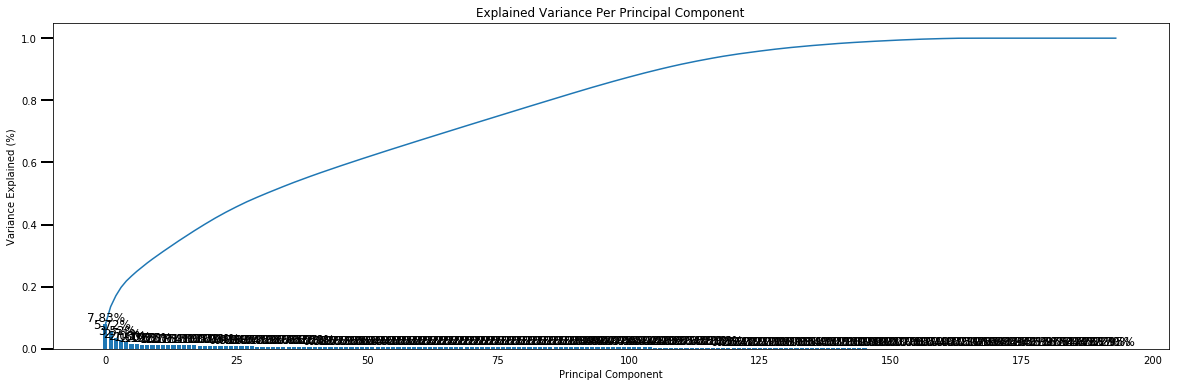

In [65]:
vals = pca.explained_variance_ratio_
num_components=len(vals)
ind = np.arange(num_components)
plt.figure(figsize=(20, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')
plt.show()

In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.

n_pca = 25

pca = PCA(n_pca)
df_pca = pca.fit_transform(df_scaled)
print('Reduced PCA found')

Reduced PCA found


### Discussion 2.2: Perform Dimensionality Reduction

Q - How many principal components / transformed features are you retaining for the next step of the analysis?

I am retaining 25 principal components. 

The decision was to get the enough variance from the dataset, but to lose at least one order of magnitude of variables.

We have at about half of the variance captured. More variables would increase very slow the variance capture from that point.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_principal_columns(pca_number = 0):
    pca_vec_col = dfcleaned.columns
    vector = pd.DataFrame( pca_vec_col, columns = ['scaled_feature'])
       
    pca_vectors = pca.components_[pca_number]
    vector2 = pd.DataFrame( pca_vectors, columns = ['values'])
    vector2['mod_values'] = abs(vector2['values'])
    
    vectormerged = pd.concat( [vector,vector2], axis=1 )
    vectorfinal = vectormerged.sort_values(by = 'mod_values', ascending=False)
    
    return(vectorfinal)

print('function created')

function created


THE FIRST PRINCIPAL COMPONENT

Description:
The highest absolute values of this component are: [MOBI_REGIO, LP_STATUS_GROB_1, FINANZ_MINIMALIST, KBA05_ANTG1, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_X0, PLZ8_ANTG1]

The negative value of "MOBI_REGIO" in the pca transformation indicates that the feature is best represented by the smaller values of "MOBI_REGIO", these represent a movement patterns from middle to very-high.

The positive value of "LP_STATUS_GROB_1.0" in the pca transformation indicates that the feature is best represented by the larger values of "LP_STATUS_GROB_1.0", these represent the encoded variable of "LP_STATUS_GROB" with the value "1: low-income earners". This means the vector has a representation of the low-income-earners.

The negative value of "FINANZ_MINIMALIST" in the pca transformation indicates that the feature is best represented by the smaller values of "FINANZ_MINIMALIST", these represent the Financial typology ranking from average to very-high.

The negative value of "KBA05_ANTG1" in the pca transformation indicates that the feature is best represented by the smaller values of "KBA05_ANTG1", these represent the number of 1-2 family houses in the microcell, ranking from average share to no-share.

The positive value of "HH_EINKOMMEN_SCORE" in the pca transformation indicates that the feature is best represented by the larger values of "HH_EINKOMMEN_SCORE", these represent the estimated household net income going from average income to very low income.


Conclusion:
This component is measuring customers that have low-income, are financial minimalists, and live on high movement region.


In [68]:
pca_principal_columns()

,scaled_feature,values,mod_values
47,MOBI_REGIO,-0.205494,0.205494
110,LP_STATUS_GROB_1.0,0.196747,0.196747
2,FINANZ_MINIMALIST,-0.192371,0.192371
37,KBA05_ANTG1,-0.189388,0.189388
29,HH_EINKOMMEN_SCORE,0.186791,0.186791
192,CAMEO_INTL_2015_X0,0.186293,0.186293
51,PLZ8_ANTG1,-0.182872,0.182872
53,PLZ8_ANTG3,0.181670,0.181670
41,KBA05_GBZ,-0.181385,0.181385
54,PLZ8_ANTG4,0.175858,0.175858


THE SECOND PRINCIPAL COMPONENT

Description:
The highest absolute values of this component are: [PRAEGENDE_JUGENDJAHRE_decade, ALTERSKATEGORIE_GROB, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_UNAUFFAELLIGER, SEMIO_REL, SEMIO_TRADV]

The negative value of "PRAEGENDE_JUGENDJAHRE_decade" in the pca transformation indicates that the feature is best represented by the smaller values of "PRAEGENDE_JUGENDJAHRE_decade", these represent the decade from the person youth with values between 1940 and 1960.

The positive value of "ALTERSKATEGORIE_GROB" in the pca transformation indicates that the feature is best represented by the larger values of "ALTERSKATEGORIE_GROB", these represent the estimated age based on given name analysis ranging from 46 years to >60years.

The negative value of "FINANZ_SPARER" in the pca transformation indicates that the feature is best represented by the smaller values of "FINANZ_SPARER", these represent the Financial typology going to average to very-high.

The positive value of "FINANZ_VORSORGER" in the pca transformation indicates that the feature is best represented by the larger values of "FINANZ_VORSORGER", these represent the Financial typology going to average to very-low.


Conclusion:

This second component is measuring an older segment, that are money-saver.

In [69]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_principal_columns(1)

,scaled_feature,values,mod_values
188,PRAEGENDE_JUGENDJAHRE_decade,-0.238483,0.238483
0,ALTERSKATEGORIE_GROB,0.233128,0.233128
3,FINANZ_SPARER,-0.226427,0.226427
4,FINANZ_VORSORGER,0.219013,0.219013
6,FINANZ_UNAUFFAELLIGER,-0.215016,0.215016
13,SEMIO_REL,-0.213792,0.213792
24,SEMIO_TRADV,-0.208498,0.208498
23,SEMIO_PFLICHT,-0.204977,0.204977
5,FINANZ_ANLEGER,-0.202798,0.202798
124,ZABEOTYP_3,0.201041,0.201041


THE THIRD PRINCIPAL COMPONENT

Description:
The highest absolute values of this component are: [GREEN_AVANTGARDE, PRAEGENDE_JUGENDJAHRE_movement, LP_STATUS_FEIN_10, LP_STATUS_GROB_5, EWDICHTE, ORTSGR_KLS9, LP_STATUS_GROB_4, LP_STATUS_FEIN_9]


The positive value of "GREEN_AVANTGARDE" in the pca transformation indicates that the feature is best represented by the larger values of "GREEN_AVANTGARDE", these represent that the person had a membership in environmental sustainability as part of youth.

The negative value of "PRAEGENDE_JUGENDJAHRE_movement" in the pca transformation indicates that the feature is best represented by the smaller values of "PRAEGENDE_JUGENDJAHRE_movement", these represent the movement the person followed: Avantgarde.

The positive value of "LP_STATUS_FEIN_10.0" in the pca transformation indicates that the feature is best represented by the larger values of "LP_STATUS_FEIN_10.0", which is the encoded value 10 of the feature. The encoded feature means Social status, fine scale with the value of top earners. The positive value means the boolean is true.

The positive value of "LP_STATUS_GROB_5.0" in the pca transformation indicates that the feature is best represented by the larger values of "LP_STATUS_GROB_5.0", which is the encoded value 5 of the feature. The encoded feature means Social status, rough scale with the value of top earners. The positive value means the boolean is true.

Conclusion:

This third component is getting a direction of environmental sustainability with high income.

In [70]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_principal_columns(3)

,scaled_feature,values,mod_values
8,GREEN_AVANTGARDE,0.293785,0.293785
189,PRAEGENDE_JUGENDJAHRE_movement,-0.293785,0.293785
109,LP_STATUS_FEIN_10.0,0.244567,0.244567
114,LP_STATUS_GROB_5.0,0.244567,0.244567
43,EWDICHTE,0.211157,0.211157
58,ORTSGR_KLS9,0.205896,0.205896
113,LP_STATUS_GROB_4.0,-0.194608,0.194608
108,LP_STATUS_FEIN_9.0,-0.183631,0.183631
42,BALLRAUM,-0.173879,0.173879
44,INNENSTADT,-0.171242,0.171242


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Q - Can we interpret positive and negative values from them in a meaningful way?

The interpretation of the positive or negative values in the eignvector is the direction that the original space has.

In other words: Get one feature of a eignvector, if this feature is positive, this means the greater the value in the original space, the more it will appear in transformed space. If is negative, its the oposite.

THE FIRST PRINCIPAL COMPONENT

Description:
The highest absolute values of this component are: [MOBI_REGIO, LP_STATUS_GROB_1, FINANZ_MINIMALIST, KBA05_ANTG1, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_X0, PLZ8_ANTG1]

The negative value of "MOBI_REGIO" in the pca transformation indicates that the feature is best represented by the smaller values of "MOBI_REGIO", these represent a movement patterns from middle to very-high.

The positive value of "LP_STATUS_GROB_1.0" in the pca transformation indicates that the feature is best represented by the larger values of "LP_STATUS_GROB_1.0", these represent the encoded variable of "LP_STATUS_GROB" with the value "1: low-income earners". This means the vector has a representation of the low-income-earners.

The negative value of "FINANZ_MINIMALIST" in the pca transformation indicates that the feature is best represented by the smaller values of "FINANZ_MINIMALIST", these represent the Financial typology ranking from average to very-high.

The negative value of "KBA05_ANTG1" in the pca transformation indicates that the feature is best represented by the smaller values of "KBA05_ANTG1", these represent the number of 1-2 family houses in the microcell, ranking from average share to no-share.

The positive value of "HH_EINKOMMEN_SCORE" in the pca transformation indicates that the feature is best represented by the larger values of "HH_EINKOMMEN_SCORE", these represent the estimated household net income going from average income to very low income.


Conclusion:
This component is measuring customers that have low-income, are financial minimalists, and live on high movement region.



THE SECOND PRINCIPAL COMPONENT

Description:
The highest absolute values of this component are: [PRAEGENDE_JUGENDJAHRE_decade, ALTERSKATEGORIE_GROB, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_UNAUFFAELLIGER, SEMIO_REL, SEMIO_TRADV]

The negative value of "PRAEGENDE_JUGENDJAHRE_decade" in the pca transformation indicates that the feature is best represented by the smaller values of "PRAEGENDE_JUGENDJAHRE_decade", these represent the decade from the person youth with values between 1940 and 1960.

The positive value of "ALTERSKATEGORIE_GROB" in the pca transformation indicates that the feature is best represented by the larger values of "ALTERSKATEGORIE_GROB", these represent the estimated age based on given name analysis ranging from 46 years to >60years.

The negative value of "FINANZ_SPARER" in the pca transformation indicates that the feature is best represented by the smaller values of "FINANZ_SPARER", these represent the Financial typology going to average to very-high.

The positive value of "FINANZ_VORSORGER" in the pca transformation indicates that the feature is best represented by the larger values of "FINANZ_VORSORGER", these represent the Financial typology going to average to very-low.


Conclusion:

This second component is measuring an older segment, that are money-saver.

THE THIRD PRINCIPAL COMPONENT

Description:
The highest absolute values of this component are: [GREEN_AVANTGARDE, PRAEGENDE_JUGENDJAHRE_movement, LP_STATUS_FEIN_10, LP_STATUS_GROB_5, EWDICHTE, ORTSGR_KLS9, LP_STATUS_GROB_4, LP_STATUS_FEIN_9]


The positive value of "GREEN_AVANTGARDE" in the pca transformation indicates that the feature is best represented by the larger values of "GREEN_AVANTGARDE", these represent that the person had a membership in environmental sustainability as part of youth.

The negative value of "PRAEGENDE_JUGENDJAHRE_movement" in the pca transformation indicates that the feature is best represented by the smaller values of "PRAEGENDE_JUGENDJAHRE_movement", these represent the movement the person followed: Avantgarde.

The positive value of "LP_STATUS_FEIN_10.0" in the pca transformation indicates that the feature is best represented by the larger values of "LP_STATUS_FEIN_10.0", which is the encoded value 10 of the feature. The encoded feature means Social status, fine scale with the value of top earners. The positive value means the boolean is true.

The positive value of "LP_STATUS_GROB_5.0" in the pca transformation indicates that the feature is best represented by the larger values of "LP_STATUS_GROB_5.0", which is the encoded value 5 of the feature. The encoded feature means Social status, rough scale with the value of top earners. The positive value means the boolean is true.

Conclusion:

This third component is getting a direction of environmental sustainability with high income.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [71]:
def kmeans_score(i):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i, random_state=0, tol=0.01)
    kmeans.fit(df_pca)
    
    # compute the average within-cluster distances.
    sc = kmeans.score(df_pca)
    
    print('i: {%f}   sc: {%f} ' % (i,sc))
    return([i,-sc])

In [72]:
# Over a number of different cluster counts...
results = []

# High Granular
for i in range(1,6):
    results.append(kmeans_score(i))
    
for i in range(6,10,2):
    results.append(kmeans_score(i))

for i in range(10,51,10):
    results.append(kmeans_score(i))
    

print('Kmeans Complete')

i: {1.000000}   sc: {-69040326.954235} 
i: {2.000000}   sc: {-59729244.552268} 
i: {3.000000}   sc: {-55309146.380265} 
i: {4.000000}   sc: {-52459653.516338} 
i: {5.000000}   sc: {-50099318.026532} 
i: {6.000000}   sc: {-48642638.055697} 
i: {8.000000}   sc: {-46111799.392539} 
i: {10.000000}   sc: {-44242337.302060} 
i: {20.000000}   sc: {-38528879.100295} 
i: {30.000000}   sc: {-35535159.685878} 
i: {40.000000}   sc: {-33422243.939311} 
i: {50.000000}   sc: {-31672755.380566} 
Kmeans Complete


Some frosen results
i: {1.000000}   sc: {-69821220.583071} 
i: {2.000000}   sc: {-60599703.277922} 
i: {3.000000}   sc: {-56143951.744862} 
i: {4.000000}   sc: {-53277402.652928} 
i: {5.000000}   sc: {-51286682.585863} 
i: {10.000000}   sc: {-44865446.796657} 
i: {20.000000}   sc: {-39104320.036793} 
i: {30.000000}   sc: {-36333054.827275} 
i: {40.000000}   sc: {-34187572.188212} 
i: {50.000000}   sc: {-32468572.050572} 
i: {60.000000}   sc: {-31183652.741736} 
i: {70.000000}   sc: {-30064798.134404} 
i: {80.000000}   sc: {-29212013.573536}

In [73]:
results

[[1, 69040326.954234794],
 [2, 59729244.55226779],
 [3, 55309146.380264811],
 [4, 52459653.516337812],
 [5, 50099318.026532032],
 [6, 48642638.055697136],
 [8, 46111799.39253898],
 [10, 44242337.302060075],
 [20, 38528879.100295447],
 [30, 35535159.685878418],
 [40, 33422243.9393108],
 [50, 31672755.38056583]]

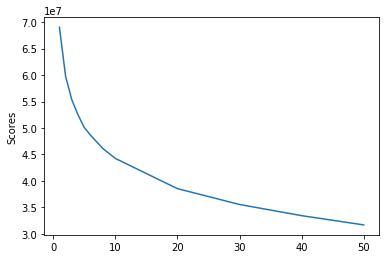

In [74]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
df_results = pd.DataFrame(results, columns=['clusters','score'])
plt.plot(df_results['clusters'],df_results['score'])
plt.ylabel('Scores')
plt.show()

In [72]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Getting the value on the graph above
number_of_clusters = 10

kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
kmeans.fit(df_pca)
  
clusters_predictions = kmeans.predict(df_pca)
print('Predictions Made')

Predictions Made


In [73]:
clusters_predictions

array([6, 1, 3, ..., 1, 2, 0], dtype=int32)

In [74]:
clusters_predictions.shape

(797906,)

### Discussion 3.1: Apply Clustering to General Population

Q - Into how many clusters have you decided to segment the population?

I have choosen to go with 10 cluster.

I used the elbow method on the graph. Since after this number the slope is too small.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [75]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
print('Data Loaded')

Data Loaded


In [76]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Cleaning Data and enconding
customers_clean = clean_data(customers)

Check if dataframes has the same shape and columns

In [77]:
# Just checking if dfcleaned and customers_clean are the same shape.
# If not, this transformation is wrong
print(customers_clean.shape)
print(dfcleaned.shape)

(141701, 193)
(797906, 194)


In [78]:
# Checking what columns were not created in the Encoder, and those that are in excess
col_train = dfcleaned.columns
col_eval = customers_clean.columns

to_create = list(set(col_train) - set(col_eval))
# to_drop = list(set(col_eval) - set(col_train))

print(to_create)
# print(to_drop)

for newcol in to_create:
    customers_clean[newcol] = 0

# Reorder to same order of the model
customers_clean = customers_clean[col_train]

print('Dataset Transformed')

['GEBAEUDETYP_5.0']
Dataset Transformed


Back to preprocessing

In [79]:
# filling Nones
customers_clean = pd.DataFrame( imputer_obj.transform(customers_clean), columns = customers_clean.columns)

# Scale by the same transformer from before
df_scaled_customer = scaler.transform(customers_clean)

print('Data Cleaned and Scaled')

Data Cleaned and Scaled


In [80]:
# Pca on the data
customer_pca = pca.transform(df_scaled_customer)

# predict cluster
customer_clusters_predictions = kmeans.predict(customer_pca)

print('Transformed')

Transformed


In [81]:
customer_clusters_predictions

array([8, 9, 3, ..., 8, 9, 4], dtype=int32)

In [82]:
df_scaled_customer

array([[ 1.18409227, -1.04391584,  1.40912169, ...,  0.21167165,
        -1.55299232,  0.0851769 ],
       [ 1.18409227,  0.95793163,  1.40912169, ...,  0.21167165,
        -0.18340929,  0.76124562],
       [ 1.18409227, -1.04391584,  1.40912169, ...,  0.21167165,
        -0.8682008 ,  0.76124562],
       ..., 
       [ 1.18409227, -1.04391584,  1.40912169, ...,  0.21167165,
        -0.8682008 ,  0.76124562],
       [ 0.20053394,  0.95793163, -0.76864185, ...,  0.21167165,
        -0.8682008 ,  0.76124562],
       [-0.78302439, -1.04391584,  1.40912169, ...,  0.21167165,
        -0.18340929,  0.0851769 ]])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
distribution_general = pd.DataFrame(clusters_predictions)[0].value_counts()/len(clusters_predictions)
distribution_customer = pd.DataFrame(customer_clusters_predictions)[0].value_counts()/len(customer_clusters_predictions)

distribution = []
for i in distribution_general.index:
    distribution.append([i,distribution_general[i],distribution_customer[i]])
df_distribution = pd.DataFrame(distribution, columns = ['group','general','customer'])
df_distribution['dif'] = df_distribution['customer'] - df_distribution['general']
df_distribution['dif_adjusted'] = df_distribution['dif']/df_distribution['general']

print('Distributions Computed')

Distributions Computed


In [84]:
df_distribution.sort_values(by='dif_adjusted', ascending=False)

,group,general,customer,dif,dif_adjusted
3,8,0.129880,0.370216,0.240336,1.850449
8,5,0.043049,0.107162,0.064113,1.489313
0,3,0.142579,0.211473,0.068894,0.483197
2,0,0.134547,0.114636,-0.019911,-0.147988
1,9,0.134923,0.107120,-0.027803,-0.206067
7,4,0.078022,0.047643,-0.030379,-0.389368
9,6,0.032820,0.008193,-0.024626,-0.750354
5,1,0.099676,0.015159,-0.084517,-0.847920
6,2,0.087282,0.008292,-0.078990,-0.904997
4,7,0.117222,0.010106,-0.107116,-0.913789


In [85]:
# plotting results
df_distribution = df_distribution.sort_values(by='group', ascending=False)

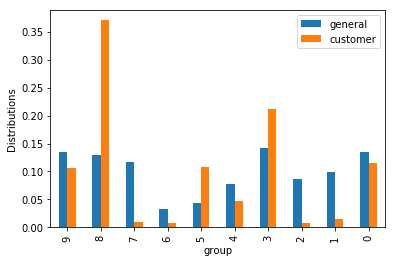

In [86]:
# Plottin the general and customer distribution
df_distribution.plot(x = 'group', y = ['general','customer'], kind = 'bar')
plt.ylabel('Distributions')
plt.show()

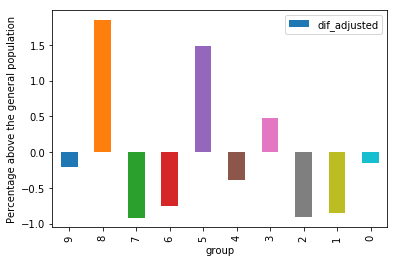

In [87]:
# Plottin the Percentage above the general population
df_distribution.plot(x = 'group', y = 'dif_adjusted', kind = 'bar')
plt.ylabel('Percentage above the general population')
plt.show()

What kinds of people are part of a cluster that is overrepresented in the
customer data compared to the general population?

In [91]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# The Groups Overrepresented are 8,5,3 in this order
# Lets discor group number 8


# Getting the centroid of cluster 8
center_after_standard_pca = kmeans.cluster_centers_[8]
center_after_standard = pca.inverse_transform(center_after_standard_pca)
center = scaler.inverse_transform(center_after_standard)
center_col = customers_clean.columns
center_df = pd.DataFrame([center],columns = center_col)

print('Group 8 Described')

Group 8 Described


Looking at cluster number 8 caracteristics: 

Age: ALTERSKATEGORIE_GROB = 3.3
Age between 46 to >60

Gender: ANREDE_KZ = 1.5 
Distribution 50-50 between men and women.

Social status, rough scale: LP_STATUS_GROB. Dominant is 5.0 (top earners)


I infer that these people belong to adults/elders that have high-income of every gender.
THEY ARE CLIENT SEGMENT TO TARGET

In [107]:
center_df[['ALTERSKATEGORIE_GROB','ANREDE_KZ','LP_STATUS_GROB_1.0','LP_STATUS_GROB_2.0','LP_STATUS_GROB_3.0','LP_STATUS_GROB_4.0','LP_STATUS_GROB_5.0']]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0
0,1.789819,1.99218,0.94636,0.035806,0.010816,-0.002927,0.006306


In [99]:
center_df

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,...,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_nation_east,PRAEGENDE_JUGENDJAHRE_nation_west,CAMEO_INTL_2015_X0,CAMEO_INTL_2015_0X
0,3.282987,1.520233,4.521707,1.737421,4.113094,1.899913,2.231948,1.986122,1.003401,2.062811,3.628009,4.066727,3.457916,3.031567,3.237836,4.638142,5.120905,5.13479,3.502329,3.275072,4.373858,4.751911,4.286148,3.280318,3.171852,0.008145,1.475811,2.243217,-0.003674,2.303525,3.90484,8.664419,1.1884,-0.021801,3.541969,1993.076381,0.086974,2.839257,0.988207,0.017343,0.017405,4.126753,4.166718,3.88001,4.749724,4.125086,2.185569,4.232553,3.214474,3.427089,...,0.027475,0.011885,0.012604,0.076742,0.020126,0.048632,0.02824,0.063794,0.127375,0.023911,0.016034,0.058931,0.060489,0.0475,0.010378,0.08642,0.01862,0.010637,0.00647,0.014032,0.00757,0.009335,0.006974,0.00844,0.003034,0.055532,0.015148,0.00432,0.003239,0.003915,0.025292,0.004213,0.002846,0.001689,0.003845,0.007671,0.013489,0.012918,0.005141,0.008618,0.010866,0.007176,0.003822,-0.000172,67.212862,-0.003401,0.580343,0.947803,2.083948,3.539131


What kinds of people are part of a cluster that is underrepresented in the
customer data compared to the general population?

In [104]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# The Groups underrepresented are 7,2,6,1 in this order
# Lets discor group number 7

# Getting the centroid of cluster 7
center_after_standard_pca = kmeans.cluster_centers_[7]
center_after_standard = pca.inverse_transform(center_after_standard_pca)
center = scaler.inverse_transform(center_after_standard)
center_col = customers_clean.columns
center_df = pd.DataFrame([center],columns = center_col)

print('Group 7 Described')

Group 7 Described


Looking at cluster number 7 caracteristics: 

Age: ALTERSKATEGORIE_GROB = 1.8
Age between <30 to 40

Gender: ANREDE_KZ = 1.99 
Distribution tending to women.

Social status, rough scale: LP_STATUS_GROB. Dominant is 1.0 (low-income earners)

I infer that these people belong to young adults, women and have low-income.
THEY ARE NOT CLIENT SEGMENT TO TARGET

In [105]:
center_df[['ALTERSKATEGORIE_GROB','ANREDE_KZ','LP_STATUS_GROB_1.0','LP_STATUS_GROB_2.0','LP_STATUS_GROB_3.0','LP_STATUS_GROB_4.0','LP_STATUS_GROB_5.0','FINANZ_MINIMALIST']]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,FINANZ_MINIMALIST
0,1.789819,1.99218,0.94636,0.035806,0.010816,-0.002927,0.006306,1.119593


In [106]:
center_df

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,...,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_nation_east,PRAEGENDE_JUGENDJAHRE_nation_west,CAMEO_INTL_2015_X0,CAMEO_INTL_2015_0X
0,1.789819,1.99218,1.119593,4.431179,2.171639,4.314541,3.845449,4.235025,0.032011,2.180299,2.628509,3.323008,3.892133,5.285391,4.635779,2.256113,3.216964,4.391556,4.013107,5.913888,5.486617,6.04366,6.043647,6.028996,5.252362,0.008055,1.545241,1.456041,-0.002852,5.554414,4.210857,7.213292,14.128946,0.040055,2.157321,1992.49132,0.256122,0.576342,1.343478,1.015508,0.568267,2.341436,3.336557,5.03632,3.525579,3.403608,2.87563,1.948129,2.797741,4.933221,...,0.011752,0.003197,0.001859,0.004056,0.000735,-0.002469,-0.002045,-0.001116,0.006772,-0.000666,-0.003593,0.013663,0.013679,0.002377,0.002534,0.009497,0.002409,0.003449,0.021304,0.013487,0.005684,0.01735,0.00523,0.002917,0.012237,0.071597,0.023503,0.006449,0.016175,0.005547,0.06248,0.053125,0.019694,0.011274,0.005017,0.134282,0.067357,0.056721,0.02316,0.053532,0.077374,0.071319,0.08671,0.005406,85.245973,0.967989,0.884751,0.951646,4.299901,2.103929


Now lets see the segment with same proportion to the population.

In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# The Groups underrepresented are  9,4,0 in this order
# Lets discor group number 0

# Getting the centroid of cluster 0
center_after_standard_pca = kmeans.cluster_centers_[0]
center_after_standard = pca.inverse_transform(center_after_standard_pca)
center = scaler.inverse_transform(center_after_standard)
center_col = customers_clean.columns
center_df = pd.DataFrame([center],columns = center_col)

print('Group 0 Described')

Group 0 Described


Looking at cluster number 0 caracteristics: 

Age: ALTERSKATEGORIE_GROB = 3.2
Age between 46 to 50

Gender: ANREDE_KZ = 1.1 
Distribution tending to Men.

Social status, rough scale: LP_STATUS_GROB. Dominant is 1.0 (low-income earners)

I infer that these people belong to young adults, men and have low-income.
They are neither the target nor the non-target.

In [109]:
center_df[['ALTERSKATEGORIE_GROB','ANREDE_KZ','LP_STATUS_GROB_1.0','LP_STATUS_GROB_2.0','LP_STATUS_GROB_3.0','LP_STATUS_GROB_4.0','LP_STATUS_GROB_5.0','FINANZ_MINIMALIST']]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,FINANZ_MINIMALIST
0,3.227171,1.07662,0.609363,0.261978,0.021702,0.083104,0.017466,3.264907


In [110]:
center_df

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,...,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_nation_east,PRAEGENDE_JUGENDJAHRE_nation_west,CAMEO_INTL_2015_X0,CAMEO_INTL_2015_0X
0,3.227171,1.07662,3.264907,1.92209,4.246445,1.577105,1.699415,3.588307,0.092083,2.26479,4.487897,5.320066,5.177326,3.936551,4.11512,5.737971,4.880492,4.191373,5.026726,2.756274,3.726774,3.378254,3.04943,3.532132,3.006276,0.007264,1.637128,1.383778,0.005161,5.378791,4.896951,8.181335,14.915867,0.079814,2.223913,1992.42356,0.234376,0.460835,1.385231,1.098189,0.581323,2.229468,3.249969,5.009842,3.518196,3.463948,2.833479,1.87002,1.760977,4.859631,...,0.001885,0.002196,0.004086,-0.002618,0.002139,-0.002214,0.000249,-0.002776,0.013512,-0.000091,-0.000239,0.020647,0.010865,0.000935,0.001589,0.019712,0.006245,0.001937,0.005931,0.001975,0.004526,0.025695,0.00307,0.005744,0.008422,0.066182,0.017401,0.009783,0.034844,0.010315,0.049548,0.049706,0.020585,0.013672,0.009963,0.132642,0.069047,0.07519,0.049836,0.045596,0.058503,0.065292,0.06594,0.01746,64.815562,0.907917,0.786842,0.953428,4.306987,2.463419


### Discussion 3.3: Compare Customer Data to Demographics Data

Q - Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

Yes, it is possible to segmente in the categories. Below we can see which ones are the target audience, not target and in the middle. 

- Popular   segments: 8,5,3
- Unpopular segments: 7,2,6,1
- normal    segments: 9,4,0


In the code above I enter in more detail of the variables to conclude the segments below.

- segment 8: these people belong to adults/elders that have high-income of every gender. (target-audience)
- segment 7: these people belong to young adults, women and have low-income. (NOT target-audience)
- segment 0: these people belong to young adults, men and have low-income. (In the middle)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.